### 工作進度  

* FinMind數據已修復，因此重新建立資料庫。  
  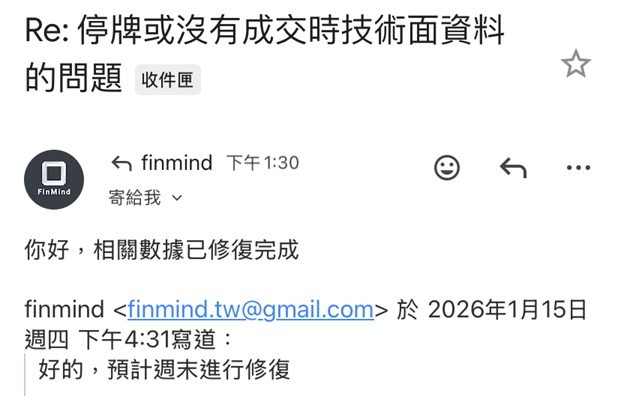    

* 重新建立「量化技術分析」資料庫。 

In [1]:
import os
import sys
import pandas as pd
import datetime
import sqlite3
import requests
import time

from dotenv import load_dotenv, find_dotenv
from FinMind.data import DataLoader

In [2]:
# python 取得時間範圍內日期列表
# 來源：https://www.cnblogs.com/xiao-xue-di/p/11900649.html

def date_range(beginDate, endDate):
    dates = []
    dt = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    date = beginDate[:]
    while date <= endDate:
        dates.append(date)
        dt = dt + datetime.timedelta(1)
        date = dt.strftime("%Y-%m-%d")
    return dates

In [3]:
# 取得範圍日期列表(2019年12月30日至2026年1月18日)
price_date_list = date_range('2019-12-30', '2026-01-18')

In [4]:
# 設定FinMind API
load_dotenv(find_dotenv())
token = os.environ.get('FINMIND_TOKEN')
api = DataLoader()
api.login_by_token(api_token=token)

In [5]:
#API 使用次數
def api_usage() :
    url = "https://api.web.finmindtrade.com/v2/user_info"
    payload = {
        "token": token,
    }
    resp = requests.get(url, params=payload)
    return resp.json()["user_count"],resp.json()["api_request_limit"]

In [6]:
print(api_usage())

(1, 1600)


In [7]:
# 連線資料庫
conn = sqlite3.connect('data/stock.db')
cursor = conn.cursor()

In [8]:
# 啟用外鍵支持
conn.execute('PRAGMA foreign_keys = ON;')

res = conn.execute('PRAGMA foreign_keys;')
res.fetchone()

(1,)

In [9]:
# 設定資料庫結構
cursor.execute('''
CREATE TABLE IF NOT EXISTS StockInfo
(
    StockID TEXT NOT NULL PRIMARY KEY ,
    StockName TEXT,
    IndustryCategory TEXT,
    Type TEXT
);
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS DailyPrice
(
    SerialNo INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    StockID TEXT NOT NULL,
    Date TEXT,
    Open REAL,
    High REAL,
    Low REAL,
    Close REAL,
    Volume INTEGER,
    Value INTEGER,
    
    FOREIGN KEY (StockID) REFERENCES StockInfo (StockID)
);
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS WeeklyPrice
(
    SerialNo INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    StockID TEXT NOT NULL,
    Date TEXT,
    Open REAL,
    High REAL,
    Low REAL,
    Close REAL,
    Volume INTEGER,
    Value INTEGER,
    
    FOREIGN KEY (StockID) REFERENCES StockInfo (StockID)
);
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS MonthlyPrice
(
    SerialNo INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    StockID TEXT NOT NULL,
    Date TEXT,
    Open REAL,
    High REAL,
    Low REAL,
    Close REAL,
    Volume INTEGER,
    Value INTEGER,
    
    FOREIGN KEY (StockID) REFERENCES StockInfo (StockID)
);
''')
conn.commit()

In [10]:
# 台股總覽 TaiwanStockInfo #
df = api.taiwan_stock_info()
# display(df)
df_stock_info = df.drop(columns=['date'])
df_stock_info = df_stock_info.rename(columns={'stock_id':'StockID','stock_name':'StockName','industry_category':'IndustryCategory','type':'Type'})
df_stock_info.drop_duplicates(subset=['StockID'], keep='first', inplace=True)
display(df_stock_info)
for idx in range(df_stock_info.shape[0]) :
    info = df_stock_info.iloc[idx]
    conn.execute("INSERT INTO StockInfo(StockID,StockName,IndustryCategory,Type) VALUES(?,?,?,?)", (info['StockID'],info['StockName'],info['IndustryCategory'],info['Type']))

2026-01-19 07:33:42.816 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockInfo, data_id: 


,IndustryCategory,StockID,StockName,Type
0,電腦及週邊設備業,5450,寶聯通,tpex
1,光電業,3629,地心引力,tpex
2,文化創意業,3687,歐買尬,tpex
3,電子零組件業,5481,新華,tpex
4,其他電子類,6238,勝麗,tpex
...,...,...,...,...
4038,Index,BiotechnologyMedicalCare,生技醫療類指數,twse
4039,Index,Automobile,汽車類指數,twse
4040,大盤,TPEx,櫃買指數,tpex
4041,Index,Food,食品類指數,twse


In [11]:
for price_date in price_date_list :
    # API 使用次數 #
    user_count,api_request_limit = api_usage()
    if user_count > (api_request_limit - 100) :
        print('抓取資料速度過快（user_count＝ {} ，api_request_limit ＝ {}），等三十分鐘後再行抓取'.format(user_count,api_request_limit))
        time.sleep(30*60)
        
    # 股價日成交資訊 TaiwanStockPrice：一次拿特定日期，所有資料(只限 backer、sponsor 使用) #
    while True :
        try :
            df = api.taiwan_stock_daily(start_date=price_date,)
        except Exception as e:
            print('日K：日期{}發生錯誤{}，重試'.format(price_date,e))
            continue
        break
    if df.empty is not True :
        print('日K：{}'.format(price_date))
        df_daily_price = df.drop(columns=['spread','Trading_turnover'])
        df_daily_price = df_daily_price.rename(columns={'date':'Date','stock_id':'StockID','Trading_Volume':'Volume','Trading_money':'Value','open':'Open','max':'High','min':'Low','close':'Close'})
        # 保存格式：日期、股票代碼、開盤價、最高價、最低價、收盤價、成交量與成交值
        df_daily_price = df_daily_price[['Date', 'StockID', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value']]
        # 排除掉非TaiwanStockInfo內的股票
        df_daily_price = df_daily_price[df_daily_price['StockID'].isin(df_stock_info['StockID'].to_list())]
        df_daily_price.to_sql('DailyPrice', conn, if_exists='append', index=False)
    else :    
        time.sleep(1)
    
    # 台股週 K 資料表 TaiwanStockWeekPrice (只限 backer、sponsor 會員使用) ： 一次拿特定日期，所有資料(只限 backer、sponsor 使用) #
    url = "https://api.finmindtrade.com/api/v4/data"
    parameter = {
        "dataset": "TaiwanStockWeekPrice",
        "start_date": price_date,
        "token": token,
    }
    while True :
        resp = requests.get(url, params=parameter)
        if resp.status_code == 200 :
            break
        else :
            print('週K：日期{}發生錯誤，回應狀態碼 ＝ {}'.format(price_date,resp.status_code))
            if resp.status_code == 402 :
                print('週K：API 用量超出上限，等十分鐘後重試')
                time.sleep(10*60)
    data = resp.json()
    df_weekly_price = pd.DataFrame(data["data"])
    if df_weekly_price.empty is not True :
        print('週K：{}'.format(price_date))
        df_weekly_price = df_weekly_price.drop(columns=['yweek','spread','trading_turnover'])
        df_weekly_price = df_weekly_price.rename(columns={'date':'Date','stock_id':'StockID','trading_volume':'Volume','trading_money':'Value','open':'Open','max':'High','min':'Low','close':'Close'})
        # 保存格式：日期、股票代碼、開盤價、最高價、最低價、收盤價、成交量與成交值
        df_weekly_price = df_weekly_price[['Date', 'StockID', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value']]
        # 排除掉非TaiwanStockInfo內的股票
        df_weekly_price = df_weekly_price[df_weekly_price['StockID'].isin(df_stock_info['StockID'].to_list())]
        df_weekly_price.to_sql('WeeklyPrice', conn, if_exists='append', index=False)
    else :    
        time.sleep(1)
    
    # 台股月 K 資料表 TaiwanStockMonthPrice (只限 backer、sponsor 會員使用) ： 一次拿特定日期，所有資料(只限 backer、sponsor 使用) #
    url = "https://api.finmindtrade.com/api/v4/data"
    parameter = {
        "dataset": "TaiwanStockMonthPrice",
        "start_date": price_date,
        "token": token, 
    }
    while True :
        resp = requests.get(url, params=parameter)
        if resp.status_code == 200 :
            break
        else :
            print('月K：日期{}發生錯誤，回應狀態碼 ＝ {}'.format(price_date,resp.status_code))
            if resp.status_code == 402 :
                print('月K：API 用量超出上限，等十分鐘後重試')
                time.sleep(10*60)
    data = resp.json()
    df_monthly_price = pd.DataFrame(data["data"])
    if df_monthly_price.empty is not True :
        print('月K：{}'.format(price_date))
        df_monthly_price = df_monthly_price.drop(columns=['ymonth','spread','trading_turnover'])
        df_monthly_price = df_monthly_price.rename(columns={'date':'Date','stock_id':'StockID','trading_volume':'Volume','trading_money':'Value','open':'Open','max':'High','min':'Low','close':'Close'})
        # 保存格式：日期、股票代碼、開盤價、最高價、最低價、收盤價、成交量與成交值
        df_monthly_price = df_monthly_price[['Date', 'StockID', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value']]
        # 排除掉非TaiwanStockInfo內的股票
        df_monthly_price = df_monthly_price[df_monthly_price['StockID'].isin(df_stock_info['StockID'].to_list())]
        df_monthly_price.to_sql('MonthlyPrice', conn, if_exists='append', index=False)
    else :    
        time.sleep(1)

2026-01-19 07:33:43.433 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2019-12-30
週K：2019-12-30


2026-01-19 07:33:46.845 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2019-12-31


2026-01-19 07:33:49.905 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:33:53.179 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-01-01
日K：2020-01-02


2026-01-19 07:33:56.271 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-03


2026-01-19 07:33:59.383 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:02.937 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:06.494 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-06
週K：2020-01-06


2026-01-19 07:34:09.348 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-07


2026-01-19 07:34:12.508 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-08


2026-01-19 07:34:15.664 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-09


2026-01-19 07:34:18.806 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-10


2026-01-19 07:34:21.956 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:25.538 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:29.104 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-13
週K：2020-01-13


2026-01-19 07:34:31.792 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-14


2026-01-19 07:34:35.575 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-15


2026-01-19 07:34:38.702 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-16


2026-01-19 07:34:41.852 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-17


2026-01-19 07:34:44.950 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:48.504 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:52.060 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-20
週K：2020-01-20


2026-01-19 07:34:54.644 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:34:58.183 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:01.731 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:05.257 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:08.830 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:12.386 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:15.933 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2020-01-27


2026-01-19 07:35:19.234 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:22.811 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:26.345 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-30


2026-01-19 07:35:29.427 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-01-31


2026-01-19 07:35:32.548 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:35.770 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-02-01


2026-01-19 07:35:39.352 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-03
週K：2020-02-03


2026-01-19 07:35:42.304 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-04


2026-01-19 07:35:45.565 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-05


2026-01-19 07:35:48.679 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-06


2026-01-19 07:35:51.817 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-07


2026-01-19 07:35:54.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:35:58.447 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:36:01.983 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-10
週K：2020-02-10


2026-01-19 07:36:04.703 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-11


2026-01-19 07:36:07.816 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-12


2026-01-19 07:36:11.075 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-13


2026-01-19 07:36:14.306 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-14


2026-01-19 07:36:17.461 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:36:21.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:36:24.629 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-17
週K：2020-02-17


2026-01-19 07:36:27.859 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-18


2026-01-19 07:36:30.960 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-19


2026-01-19 07:36:34.229 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-20


2026-01-19 07:36:37.352 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-21


2026-01-19 07:36:40.766 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:36:44.343 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:36:47.905 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-24
週K：2020-02-24


2026-01-19 07:36:50.568 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-25


2026-01-19 07:36:53.694 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-26


2026-01-19 07:36:56.991 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-02-27


2026-01-19 07:37:00.159 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:04.146 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:07.766 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:11.143 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-03-01
日K：2020-03-02
週K：2020-03-02


2026-01-19 07:37:14.554 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-03


2026-01-19 07:37:17.721 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-04


2026-01-19 07:37:20.919 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-05


2026-01-19 07:37:24.416 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-06


2026-01-19 07:37:28.156 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:31.719 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:35.283 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-09
週K：2020-03-09


2026-01-19 07:37:38.342 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-10


2026-01-19 07:37:41.690 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-11


2026-01-19 07:37:45.067 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-12


2026-01-19 07:37:48.403 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-13


2026-01-19 07:37:51.603 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:55.169 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:37:58.719 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-16
週K：2020-03-16


2026-01-19 07:38:01.456 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-17


2026-01-19 07:38:04.543 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-18


2026-01-19 07:38:07.625 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-19


2026-01-19 07:38:10.627 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-20


2026-01-19 07:38:13.611 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:38:17.228 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:38:20.792 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-23
週K：2020-03-23


2026-01-19 07:38:23.274 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-24


2026-01-19 07:38:26.307 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-25


2026-01-19 07:38:29.335 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-26


2026-01-19 07:38:32.278 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-27


2026-01-19 07:38:35.256 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:38:38.846 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:38:42.405 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-30
週K：2020-03-30


2026-01-19 07:38:44.993 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-03-31


2026-01-19 07:38:47.901 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-01


2026-01-19 07:38:50.556 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-04-01


2026-01-19 07:38:54.147 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:38:57.736 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:01.282 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:04.865 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-06
週K：2020-04-06


2026-01-19 07:39:07.535 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-07


2026-01-19 07:39:10.639 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-08


2026-01-19 07:39:13.769 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-09


2026-01-19 07:39:16.837 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-10


2026-01-19 07:39:19.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:23.415 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:26.990 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-13
週K：2020-04-13


2026-01-19 07:39:30.351 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-14


2026-01-19 07:39:33.576 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-15


2026-01-19 07:39:36.762 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-16


2026-01-19 07:39:39.839 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-17


2026-01-19 07:39:43.136 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:46.756 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:39:50.348 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-20
週K：2020-04-20


2026-01-19 07:39:53.036 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-21


2026-01-19 07:39:56.193 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-22


2026-01-19 07:40:00.534 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-23


2026-01-19 07:40:03.636 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-24


2026-01-19 07:40:07.077 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:10.665 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:14.433 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-27
週K：2020-04-27


2026-01-19 07:40:17.429 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-28


2026-01-19 07:40:20.522 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-29


2026-01-19 07:40:23.668 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-04-30


2026-01-19 07:40:26.786 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:30.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-05-01


2026-01-19 07:40:33.702 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:37.279 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-04
週K：2020-05-04


2026-01-19 07:40:39.989 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-05


2026-01-19 07:40:43.083 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-06


2026-01-19 07:40:46.142 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-07


2026-01-19 07:40:49.357 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-08


2026-01-19 07:40:52.498 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:56.044 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:40:59.605 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-11
週K：2020-05-11


2026-01-19 07:41:02.407 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-12


2026-01-19 07:41:05.704 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-13


2026-01-19 07:41:10.490 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-14


2026-01-19 07:41:13.543 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-15


2026-01-19 07:41:16.708 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:41:20.278 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:41:23.828 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-18
週K：2020-05-18


2026-01-19 07:41:26.725 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-19


2026-01-19 07:41:29.777 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-20


2026-01-19 07:41:32.825 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-21


2026-01-19 07:41:35.885 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-22


2026-01-19 07:41:38.953 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:41:42.477 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:41:46.046 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-25
週K：2020-05-25


2026-01-19 07:41:48.939 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-26


2026-01-19 07:41:52.111 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-27


2026-01-19 07:41:55.160 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-28


2026-01-19 07:41:58.213 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-05-29


2026-01-19 07:42:01.258 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:04.791 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:08.322 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-01
週K：2020-06-01
月K：2020-06-01


2026-01-19 07:42:11.062 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-02


2026-01-19 07:42:14.476 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-03


2026-01-19 07:42:17.562 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-04


2026-01-19 07:42:20.649 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-05


2026-01-19 07:42:23.722 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:27.274 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:30.827 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-08
週K：2020-06-08


2026-01-19 07:42:33.613 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-09


2026-01-19 07:42:36.693 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-10


2026-01-19 07:42:39.775 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-11


2026-01-19 07:42:42.878 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-12


2026-01-19 07:42:45.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:49.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:42:53.080 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-15
週K：2020-06-15


2026-01-19 07:42:55.771 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-16


2026-01-19 07:42:58.810 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-17


2026-01-19 07:43:01.887 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-18


2026-01-19 07:43:04.945 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-19


2026-01-19 07:43:08.014 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:11.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:15.108 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-22
週K：2020-06-22


2026-01-19 07:43:18.097 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-23


2026-01-19 07:43:21.157 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-24


2026-01-19 07:43:24.208 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:27.765 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:31.341 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:34.902 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:38.421 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-29
週K：2020-06-29


2026-01-19 07:43:41.633 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-06-30


2026-01-19 07:43:44.789 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-01


2026-01-19 07:43:47.649 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-07-01
日K：2020-07-02


2026-01-19 07:43:50.755 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-03


2026-01-19 07:43:53.865 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:43:57.414 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:44:01.417 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-06
週K：2020-07-06


2026-01-19 07:44:04.137 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-07


2026-01-19 07:44:07.266 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-08


2026-01-19 07:44:10.334 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-09


2026-01-19 07:44:13.536 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-10


2026-01-19 07:44:16.748 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:44:20.315 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:44:23.877 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-13
週K：2020-07-13


2026-01-19 07:44:26.522 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-14


2026-01-19 07:44:29.607 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-15


2026-01-19 07:44:32.698 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-16


2026-01-19 07:44:35.758 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-17


2026-01-19 07:44:38.826 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:44:42.377 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:44:45.914 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-20
週K：2020-07-20


2026-01-19 07:44:48.686 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-21


2026-01-19 07:44:51.796 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-22


2026-01-19 07:44:54.959 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-23


2026-01-19 07:44:58.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-24


2026-01-19 07:45:01.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:45:04.731 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:45:08.441 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-27
週K：2020-07-27


2026-01-19 07:45:11.208 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-28


2026-01-19 07:45:14.317 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-29


2026-01-19 07:45:17.407 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-30


2026-01-19 07:45:20.529 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-07-31


2026-01-19 07:45:23.609 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:45:27.000 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-08-01


2026-01-19 07:45:30.551 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-03
週K：2020-08-03


2026-01-19 07:45:33.463 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-04


2026-01-19 07:45:36.536 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-05


2026-01-19 07:45:39.635 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-06


2026-01-19 07:45:42.735 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-07


2026-01-19 07:45:45.842 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:45:49.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:45:52.963 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-10
週K：2020-08-10


2026-01-19 07:45:56.055 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-11


2026-01-19 07:45:59.152 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-12


2026-01-19 07:46:02.943 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-13


2026-01-19 07:46:06.041 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-14


2026-01-19 07:46:09.240 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:46:12.795 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:46:16.330 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-17
週K：2020-08-17


2026-01-19 07:46:19.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-18


2026-01-19 07:46:22.125 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-19


2026-01-19 07:46:25.299 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-20


2026-01-19 07:46:28.525 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-21


2026-01-19 07:46:31.603 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:46:35.156 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:46:38.733 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-24
週K：2020-08-24


2026-01-19 07:46:41.531 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-25


2026-01-19 07:46:44.613 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-26


2026-01-19 07:46:47.696 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-27


2026-01-19 07:46:51.002 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-28


2026-01-19 07:46:54.520 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:46:58.095 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:47:01.697 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-08-31
週K：2020-08-31


2026-01-19 07:47:04.476 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-01


2026-01-19 07:47:07.713 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-09-01
日K：2020-09-02


2026-01-19 07:47:10.831 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-03


2026-01-19 07:47:13.964 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-04


2026-01-19 07:47:17.181 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:47:20.881 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:47:24.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-07
週K：2020-09-07


2026-01-19 07:47:27.704 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-08


2026-01-19 07:47:31.162 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-09


2026-01-19 07:47:34.421 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-10


2026-01-19 07:47:37.570 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-11


2026-01-19 07:47:40.788 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:47:44.331 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:47:47.927 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-14
週K：2020-09-14


2026-01-19 07:47:50.716 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-15


2026-01-19 07:47:53.864 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-16


2026-01-19 07:47:57.014 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-17


2026-01-19 07:48:00.169 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-18


2026-01-19 07:48:03.352 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:06.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:10.454 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-21
週K：2020-09-21


2026-01-19 07:48:13.790 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-22


2026-01-19 07:48:16.942 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-23


2026-01-19 07:48:20.057 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-24


2026-01-19 07:48:23.166 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-25


2026-01-19 07:48:26.286 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:29.863 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:33.418 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-28
週K：2020-09-28


2026-01-19 07:48:36.431 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-29


2026-01-19 07:48:39.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-09-30


2026-01-19 07:48:42.793 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-10-01


2026-01-19 07:48:46.213 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:49.911 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:53.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:48:57.241 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-05
週K：2020-10-05


2026-01-19 07:49:00.113 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-06


2026-01-19 07:49:03.252 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-07


2026-01-19 07:49:06.374 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-08


2026-01-19 07:49:09.458 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:49:13.017 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:49:16.567 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:49:20.129 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-12
週K：2020-10-12


2026-01-19 07:49:22.920 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-13


2026-01-19 07:49:26.183 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-14


2026-01-19 07:49:29.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-15


2026-01-19 07:49:32.383 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-16


2026-01-19 07:49:35.530 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:49:39.091 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:49:42.648 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-19
週K：2020-10-19


2026-01-19 07:49:45.548 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-20


2026-01-19 07:49:48.635 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-21


2026-01-19 07:49:51.740 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-22


2026-01-19 07:49:54.810 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-23


2026-01-19 07:49:58.012 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:01.579 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:05.446 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-26
週K：2020-10-26


2026-01-19 07:50:08.728 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-27


2026-01-19 07:50:11.932 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-28


2026-01-19 07:50:15.118 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-29


2026-01-19 07:50:18.228 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-10-30


2026-01-19 07:50:21.332 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:24.880 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:28.363 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2020-11-01
日K：2020-11-02
週K：2020-11-02


2026-01-19 07:50:31.288 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-03


2026-01-19 07:50:34.431 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-04


2026-01-19 07:50:37.542 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-05


2026-01-19 07:50:40.658 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-06


2026-01-19 07:50:43.785 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:47.335 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:50:50.904 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-09
週K：2020-11-09


2026-01-19 07:50:54.301 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-10


2026-01-19 07:50:57.433 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-11


2026-01-19 07:51:00.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-12


2026-01-19 07:51:03.719 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-13


2026-01-19 07:51:06.836 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:51:10.384 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:51:13.938 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-16
週K：2020-11-16


2026-01-19 07:51:17.093 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-17


2026-01-19 07:51:20.216 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-18


2026-01-19 07:51:23.330 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-19


2026-01-19 07:51:26.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-20


2026-01-19 07:51:29.710 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:51:33.280 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:51:36.838 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-23
週K：2020-11-23


2026-01-19 07:51:39.566 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-24


2026-01-19 07:51:42.681 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-25


2026-01-19 07:51:45.822 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-26


2026-01-19 07:51:49.569 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-27


2026-01-19 07:51:53.189 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:51:56.766 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:52:00.354 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-11-30
週K：2020-11-30


2026-01-19 07:52:03.563 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-01
月K：2020-12-01


2026-01-19 07:52:07.180 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-02


2026-01-19 07:52:10.379 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-03


2026-01-19 07:52:13.655 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-04


2026-01-19 07:52:16.871 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:52:20.501 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:52:24.121 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-07
週K：2020-12-07


2026-01-19 07:52:27.145 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-08


2026-01-19 07:52:30.277 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-09


2026-01-19 07:52:33.424 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-10


2026-01-19 07:52:36.599 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-11


2026-01-19 07:52:39.761 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:52:43.333 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:52:46.955 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-14
週K：2020-12-14


2026-01-19 07:52:49.964 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-15


2026-01-19 07:52:53.078 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-16


2026-01-19 07:52:56.557 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-17


2026-01-19 07:52:59.636 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-18


2026-01-19 07:53:02.707 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:06.283 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:09.893 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-21
週K：2020-12-21


2026-01-19 07:53:12.580 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-22


2026-01-19 07:53:15.720 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-23


2026-01-19 07:53:18.791 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-24


2026-01-19 07:53:22.000 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-25


2026-01-19 07:53:25.064 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:28.624 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:32.224 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-28
週K：2020-12-28


2026-01-19 07:53:35.517 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-29


2026-01-19 07:53:38.609 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-30


2026-01-19 07:53:41.688 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2020-12-31


2026-01-19 07:53:44.779 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:48.764 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-01-01


2026-01-19 07:53:52.343 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:53:55.890 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-04
週K：2021-01-04


2026-01-19 07:53:58.949 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-05


2026-01-19 07:54:02.164 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-06


2026-01-19 07:54:05.341 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-07


2026-01-19 07:54:08.519 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-08


2026-01-19 07:54:11.894 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:54:15.438 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:54:19.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-11
週K：2021-01-11


2026-01-19 07:54:22.010 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-12


2026-01-19 07:54:35.602 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-13


2026-01-19 07:54:38.859 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-14


2026-01-19 07:54:42.121 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-15


2026-01-19 07:54:45.385 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:54:48.995 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:54:52.564 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-18
週K：2021-01-18


2026-01-19 07:54:55.463 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-19


2026-01-19 07:54:58.644 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-20


2026-01-19 07:55:02.084 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-21


2026-01-19 07:55:05.283 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-22


2026-01-19 07:55:08.518 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:55:12.081 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:55:15.645 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-25
週K：2021-01-25


2026-01-19 07:55:18.588 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-26


2026-01-19 07:55:21.861 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-27


2026-01-19 07:55:25.404 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-28


2026-01-19 07:55:28.963 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-01-29


2026-01-19 07:55:32.441 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:55:36.026 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:55:39.555 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-01
週K：2021-02-01


2026-01-19 07:55:42.522 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-02-01
日K：2021-02-02


2026-01-19 07:55:45.812 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-03


2026-01-19 07:55:49.024 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-04


2026-01-19 07:55:52.214 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-05


2026-01-19 07:55:55.387 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:55:58.946 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:02.539 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-02-08


2026-01-19 07:56:05.744 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:09.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:12.892 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:16.474 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:20.040 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:23.597 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:27.156 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-02-15


2026-01-19 07:56:30.508 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:34.064 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-17


2026-01-19 07:56:37.267 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-18


2026-01-19 07:56:40.542 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-19


2026-01-19 07:56:43.818 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:47.354 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:56:50.948 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-22
週K：2021-02-22


2026-01-19 07:56:53.953 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-23


2026-01-19 07:56:57.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-24


2026-01-19 07:57:01.514 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-25


2026-01-19 07:57:05.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-02-26


2026-01-19 07:57:08.455 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:57:12.046 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:57:15.614 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-03-01


2026-01-19 07:57:18.790 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-03-01
日K：2021-03-02


2026-01-19 07:57:22.166 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-03


2026-01-19 07:57:25.509 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-04


2026-01-19 07:57:28.763 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-05


2026-01-19 07:57:32.174 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:57:35.709 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:57:39.246 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-08
週K：2021-03-08


2026-01-19 07:57:42.307 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-09


2026-01-19 07:57:45.811 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-10


2026-01-19 07:57:49.200 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-11


2026-01-19 07:57:52.560 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-12


2026-01-19 07:57:55.916 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:57:59.487 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:58:03.028 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-15
週K：2021-03-15


2026-01-19 07:58:06.055 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-16


2026-01-19 07:58:09.275 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-17


2026-01-19 07:58:12.499 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-18


2026-01-19 07:58:15.727 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-19


2026-01-19 07:58:18.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:58:22.506 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:58:26.084 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-22
週K：2021-03-22


2026-01-19 07:58:29.069 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-23


2026-01-19 07:58:32.269 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-24


2026-01-19 07:58:35.446 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-25


2026-01-19 07:58:38.642 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-26


2026-01-19 07:58:41.875 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:58:45.451 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:58:49.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-29
週K：2021-03-29


2026-01-19 07:58:52.558 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-30


2026-01-19 07:58:55.857 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-03-31


2026-01-19 07:58:59.138 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-01


2026-01-19 07:59:02.646 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-04-01


2026-01-19 07:59:06.221 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:59:09.831 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:59:13.375 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-04-05


2026-01-19 07:59:16.628 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-06


2026-01-19 07:59:19.867 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-07


2026-01-19 07:59:23.126 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-08


2026-01-19 07:59:26.460 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-09


2026-01-19 07:59:29.798 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:59:33.361 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:59:36.933 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-12
週K：2021-04-12


2026-01-19 07:59:40.218 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-13


2026-01-19 07:59:43.473 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-14


2026-01-19 07:59:46.728 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-15


2026-01-19 07:59:50.000 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-16


2026-01-19 07:59:53.274 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 07:59:56.846 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:00:00.398 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-19
週K：2021-04-19


2026-01-19 08:00:03.359 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-20


2026-01-19 08:00:07.085 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-21


2026-01-19 08:00:10.436 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-22


2026-01-19 08:00:13.705 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-23


2026-01-19 08:00:17.020 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:00:20.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:00:24.186 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-26
週K：2021-04-26


2026-01-19 08:00:27.244 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-27


2026-01-19 08:00:30.470 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-28


2026-01-19 08:00:33.745 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-04-29


2026-01-19 08:00:37.007 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:00:40.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:00:44.497 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-05-01


2026-01-19 08:00:48.087 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-03
週K：2021-05-03


2026-01-19 08:00:51.159 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-04


2026-01-19 08:00:54.418 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-05


2026-01-19 08:00:57.609 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-06


2026-01-19 08:01:00.814 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-07


2026-01-19 08:01:04.034 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:01:07.885 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 08:01:11.444 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-10
週K：2021-05-10


2026-01-19 08:01:14.476 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-11


2026-01-19 08:01:17.733 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-12
抓取資料速度過快（user_count＝ 1502 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 08:31:20.978 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-13
抓取資料速度過快（user_count＝ 1502 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 09:01:24.304 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-14


2026-01-19 09:01:27.681 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:01:31.224 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:01:34.839 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-17
週K：2021-05-17


2026-01-19 09:01:37.791 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-18


2026-01-19 09:01:40.901 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-19


2026-01-19 09:01:44.087 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-20


2026-01-19 09:01:47.148 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-21


2026-01-19 09:01:50.212 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:01:53.769 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:01:57.330 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-24
週K：2021-05-24


2026-01-19 09:02:00.130 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-25


2026-01-19 09:02:03.557 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-26


2026-01-19 09:02:06.832 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-27


2026-01-19 09:02:09.962 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-28


2026-01-19 09:02:13.271 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:02:16.822 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:02:20.376 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-05-31
週K：2021-05-31


2026-01-19 09:02:23.434 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-01


2026-01-19 09:02:26.663 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-06-01
日K：2021-06-02


2026-01-19 09:02:29.877 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-03


2026-01-19 09:02:33.039 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-04


2026-01-19 09:02:36.289 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:02:39.857 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:02:43.381 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-07
週K：2021-06-07


2026-01-19 09:02:46.284 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-08


2026-01-19 09:02:49.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-09


2026-01-19 09:02:52.530 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-10


2026-01-19 09:02:55.725 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-11


2026-01-19 09:02:58.884 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:02.456 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:06.013 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-06-14


2026-01-19 09:03:09.372 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-15


2026-01-19 09:03:12.651 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-16


2026-01-19 09:03:15.886 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-17


2026-01-19 09:03:19.111 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-18


2026-01-19 09:03:22.308 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:25.883 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:29.455 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-21
週K：2021-06-21


2026-01-19 09:03:32.512 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-22


2026-01-19 09:03:35.918 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-23


2026-01-19 09:03:39.144 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-24


2026-01-19 09:03:42.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-25


2026-01-19 09:03:45.735 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:49.296 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:03:52.874 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-28
週K：2021-06-28


2026-01-19 09:03:55.759 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-29


2026-01-19 09:03:59.053 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-06-30


2026-01-19 09:04:02.227 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-01


2026-01-19 09:04:05.967 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-07-01
日K：2021-07-02


2026-01-19 09:04:09.166 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:04:12.756 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:04:16.312 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-05
週K：2021-07-05


2026-01-19 09:04:19.290 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-06


2026-01-19 09:04:22.952 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-07


2026-01-19 09:04:26.182 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-08


2026-01-19 09:04:29.493 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-09


2026-01-19 09:04:32.846 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:04:36.414 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:04:39.976 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-12
週K：2021-07-12


2026-01-19 09:04:42.985 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-13


2026-01-19 09:04:46.266 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-14


2026-01-19 09:04:49.490 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-15


2026-01-19 09:04:52.760 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-16


2026-01-19 09:04:55.957 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:04:59.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:05:03.074 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-19
週K：2021-07-19


2026-01-19 09:05:06.182 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-20


2026-01-19 09:05:09.487 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-21


2026-01-19 09:05:12.669 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-22


2026-01-19 09:05:15.902 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-23


2026-01-19 09:05:19.097 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:05:22.626 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:05:26.287 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-26
週K：2021-07-26


2026-01-19 09:05:29.135 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-27


2026-01-19 09:05:32.380 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-28


2026-01-19 09:05:35.643 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-29


2026-01-19 09:05:38.812 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-07-30


2026-01-19 09:05:41.963 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:05:46.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:05:49.503 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-08-01
日K：2021-08-02
週K：2021-08-02


2026-01-19 09:05:52.503 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-03


2026-01-19 09:05:55.682 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-04


2026-01-19 09:05:58.892 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-05


2026-01-19 09:06:02.171 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-06


2026-01-19 09:06:05.425 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:09.085 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:12.682 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-09
週K：2021-08-09


2026-01-19 09:06:15.549 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-10


2026-01-19 09:06:18.694 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-11


2026-01-19 09:06:21.836 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-12


2026-01-19 09:06:24.948 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-13


2026-01-19 09:06:28.160 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:31.740 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:35.301 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-16
週K：2021-08-16


2026-01-19 09:06:38.103 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-17


2026-01-19 09:06:41.183 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-18


2026-01-19 09:06:44.426 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-19


2026-01-19 09:06:47.605 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-20


2026-01-19 09:06:50.711 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:54.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:06:57.814 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-23
週K：2021-08-23


2026-01-19 09:07:01.006 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-24


2026-01-19 09:07:04.181 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-25


2026-01-19 09:07:07.413 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-26


2026-01-19 09:07:10.570 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-27


2026-01-19 09:07:13.850 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:07:17.438 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:07:21.008 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-30
週K：2021-08-30


2026-01-19 09:07:23.982 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-08-31


2026-01-19 09:07:27.082 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-01


2026-01-19 09:07:30.741 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-09-01
日K：2021-09-02


2026-01-19 09:07:33.882 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-03


2026-01-19 09:07:37.124 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:07:40.722 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:07:44.322 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-06
週K：2021-09-06


2026-01-19 09:07:47.344 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-07


2026-01-19 09:07:50.465 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-08


2026-01-19 09:07:53.584 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-09


2026-01-19 09:07:56.743 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-10


2026-01-19 09:07:59.844 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:03.689 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:07.280 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-13
週K：2021-09-13


2026-01-19 09:08:10.346 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-14


2026-01-19 09:08:13.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-15


2026-01-19 09:08:16.872 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-16


2026-01-19 09:08:20.002 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-17


2026-01-19 09:08:23.331 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:26.875 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:30.473 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-09-20


2026-01-19 09:08:33.837 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:37.393 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-22


2026-01-19 09:08:40.454 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-23


2026-01-19 09:08:43.523 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-24


2026-01-19 09:08:46.652 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:50.227 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:08:53.770 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-27
週K：2021-09-27


2026-01-19 09:08:56.679 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-28


2026-01-19 09:08:59.746 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-29


2026-01-19 09:09:02.896 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-09-30


2026-01-19 09:09:06.004 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-01


2026-01-19 09:09:08.961 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-10-01


2026-01-19 09:09:12.511 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:09:16.072 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-04
週K：2021-10-04


2026-01-19 09:09:18.856 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-05


2026-01-19 09:09:21.913 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-06


2026-01-19 09:09:25.022 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-07


2026-01-19 09:09:28.154 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-08


2026-01-19 09:09:31.258 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:09:34.834 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:09:38.403 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2021-10-11


2026-01-19 09:09:41.790 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-12


2026-01-19 09:09:44.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-13


2026-01-19 09:09:47.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-14


2026-01-19 09:09:51.061 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-15


2026-01-19 09:09:54.162 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:09:57.718 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:10:01.264 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-18
週K：2021-10-18


2026-01-19 09:10:04.098 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-19


2026-01-19 09:10:07.203 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-20


2026-01-19 09:10:10.288 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-21


2026-01-19 09:10:13.465 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-22


2026-01-19 09:10:16.672 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:10:20.220 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:10:23.776 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-25
週K：2021-10-25


2026-01-19 09:10:26.743 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-26


2026-01-19 09:10:29.869 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-27


2026-01-19 09:10:33.017 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-28


2026-01-19 09:10:36.129 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-10-29


2026-01-19 09:10:39.462 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:10:43.022 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:10:46.609 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-01
週K：2021-11-01


2026-01-19 09:10:50.231 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-11-01
日K：2021-11-02


2026-01-19 09:10:53.423 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-03


2026-01-19 09:10:56.587 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-04


2026-01-19 09:10:59.739 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-05


2026-01-19 09:11:02.874 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:06.438 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:09.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-08
週K：2021-11-08


2026-01-19 09:11:12.954 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-09


2026-01-19 09:11:16.126 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-10


2026-01-19 09:11:19.399 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-11


2026-01-19 09:11:22.658 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-12


2026-01-19 09:11:25.842 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:29.494 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:33.095 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-15
週K：2021-11-15


2026-01-19 09:11:36.031 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-16


2026-01-19 09:11:39.263 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-17


2026-01-19 09:11:42.441 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-18


2026-01-19 09:11:45.668 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-19


2026-01-19 09:11:48.891 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:52.476 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:11:56.063 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-22
週K：2021-11-22


2026-01-19 09:11:59.112 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-23


2026-01-19 09:12:02.508 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-24


2026-01-19 09:12:05.686 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-25


2026-01-19 09:12:08.879 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-26


2026-01-19 09:12:12.075 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:12:15.657 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:12:19.198 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-29
週K：2021-11-29


2026-01-19 09:12:22.118 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-11-30


2026-01-19 09:12:25.348 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-01


2026-01-19 09:12:28.557 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2021-12-01
日K：2021-12-02


2026-01-19 09:12:31.801 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-03


2026-01-19 09:12:35.097 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:12:38.648 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:12:42.218 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-06
週K：2021-12-06


2026-01-19 09:12:45.191 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-07


2026-01-19 09:12:48.410 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-08


2026-01-19 09:12:51.641 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-09


2026-01-19 09:12:54.868 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-10


2026-01-19 09:12:58.069 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:01.885 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:05.436 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-13
週K：2021-12-13


2026-01-19 09:13:08.345 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-14


2026-01-19 09:13:11.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-15


2026-01-19 09:13:14.734 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-16


2026-01-19 09:13:17.977 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-17


2026-01-19 09:13:21.187 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:24.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:28.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-20
週K：2021-12-20


2026-01-19 09:13:31.454 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-21


2026-01-19 09:13:34.677 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-22


2026-01-19 09:13:37.857 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-23


2026-01-19 09:13:41.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-24


2026-01-19 09:13:44.259 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:47.850 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:13:51.442 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-27
週K：2021-12-27


2026-01-19 09:13:54.426 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-28


2026-01-19 09:13:57.609 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-29


2026-01-19 09:14:00.890 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2021-12-30


2026-01-19 09:14:04.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:14:07.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:14:11.780 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-01-01


2026-01-19 09:14:15.354 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-03
週K：2022-01-03


2026-01-19 09:14:18.506 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-04


2026-01-19 09:14:21.745 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-05


2026-01-19 09:14:25.106 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-06


2026-01-19 09:14:28.493 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-07


2026-01-19 09:14:31.876 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:14:35.439 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:14:39.128 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-10
週K：2022-01-10


2026-01-19 09:14:42.223 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-11


2026-01-19 09:14:45.459 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-12


2026-01-19 09:14:48.626 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-13


2026-01-19 09:14:51.902 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-14


2026-01-19 09:14:55.072 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:14:58.648 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:02.575 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-17
週K：2022-01-17


2026-01-19 09:15:05.748 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-18


2026-01-19 09:15:09.012 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-19


2026-01-19 09:15:12.215 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-20


2026-01-19 09:15:15.472 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-21


2026-01-19 09:15:18.677 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:22.231 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:25.807 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-24
週K：2022-01-24


2026-01-19 09:15:29.058 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-25


2026-01-19 09:15:32.308 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-01-26


2026-01-19 09:15:35.421 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:38.977 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:42.548 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:46.108 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:49.677 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:53.207 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:15:57.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-02-01


2026-01-19 09:16:00.724 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:04.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:08.044 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:11.594 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:15.174 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-07
週K：2022-02-07


2026-01-19 09:16:18.337 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-08


2026-01-19 09:16:21.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-09


2026-01-19 09:16:25.133 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-10


2026-01-19 09:16:28.395 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-11


2026-01-19 09:16:31.610 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:35.179 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:38.749 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-14
週K：2022-02-14


2026-01-19 09:16:41.869 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-15


2026-01-19 09:16:45.056 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-16


2026-01-19 09:16:48.379 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-17


2026-01-19 09:16:51.621 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-18


2026-01-19 09:16:54.982 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:16:58.516 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:17:02.168 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-21
週K：2022-02-21


2026-01-19 09:17:05.888 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-22


2026-01-19 09:17:09.178 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-23


2026-01-19 09:17:12.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-24


2026-01-19 09:17:15.654 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-02-25


2026-01-19 09:17:18.977 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:17:22.525 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:17:26.079 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2022-02-28


2026-01-19 09:17:29.479 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-01
月K：2022-03-01


2026-01-19 09:17:33.720 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-02


2026-01-19 09:17:37.008 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-03


2026-01-19 09:17:40.326 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-04


2026-01-19 09:17:43.564 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:17:47.114 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:17:50.711 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-07
週K：2022-03-07


2026-01-19 09:17:53.765 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-08


2026-01-19 09:17:57.011 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-09


2026-01-19 09:18:00.261 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-10


2026-01-19 09:18:03.890 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-11


2026-01-19 09:18:07.100 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:18:10.632 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:18:14.173 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-14
週K：2022-03-14


2026-01-19 09:18:17.462 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-15


2026-01-19 09:18:20.669 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-16


2026-01-19 09:18:23.875 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-17


2026-01-19 09:18:27.284 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-18


2026-01-19 09:18:30.604 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:18:34.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:18:37.713 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-21
週K：2022-03-21


2026-01-19 09:18:40.846 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-22


2026-01-19 09:18:44.062 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-23


2026-01-19 09:18:47.286 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-24


2026-01-19 09:18:50.477 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-25


2026-01-19 09:18:53.758 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:18:57.325 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:19:00.858 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-28
週K：2022-03-28


2026-01-19 09:19:04.089 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-29


2026-01-19 09:19:07.283 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-30


2026-01-19 09:19:10.538 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-03-31


2026-01-19 09:19:13.713 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-01


2026-01-19 09:19:17.997 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-04-01


2026-01-19 09:19:21.574 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:19:25.135 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2022-04-04


2026-01-19 09:19:28.479 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:19:32.048 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-06


2026-01-19 09:19:35.231 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-07


2026-01-19 09:19:38.521 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-08


2026-01-19 09:19:41.809 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:19:45.355 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:19:48.919 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-11
週K：2022-04-11


2026-01-19 09:19:52.233 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-12


2026-01-19 09:19:55.449 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-13


2026-01-19 09:19:58.674 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-14


2026-01-19 09:20:02.417 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-15


2026-01-19 09:20:05.689 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:20:09.252 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:20:12.789 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-18
週K：2022-04-18


2026-01-19 09:20:16.005 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-19


2026-01-19 09:20:19.223 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-20


2026-01-19 09:20:22.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-21


2026-01-19 09:20:25.706 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-22


2026-01-19 09:20:28.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:20:32.471 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:20:36.020 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-25
週K：2022-04-25


2026-01-19 09:20:39.003 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-26


2026-01-19 09:20:42.172 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-27


2026-01-19 09:20:45.452 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-28


2026-01-19 09:20:48.655 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-04-29


2026-01-19 09:20:52.011 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:20:55.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-05-01


2026-01-19 09:20:59.923 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2022-05-02


2026-01-19 09:21:03.315 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-03


2026-01-19 09:21:06.577 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-04


2026-01-19 09:21:09.750 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-05


2026-01-19 09:21:12.967 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-06


2026-01-19 09:21:16.179 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:21:19.737 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:21:23.329 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-09
週K：2022-05-09


2026-01-19 09:21:26.435 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-10


2026-01-19 09:21:29.709 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-11


2026-01-19 09:21:32.965 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-12


2026-01-19 09:21:36.124 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-13


2026-01-19 09:21:39.261 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:21:42.792 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:21:46.343 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-16
週K：2022-05-16


2026-01-19 09:21:49.530 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-17


2026-01-19 09:21:52.697 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-18


2026-01-19 09:21:55.990 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-19


2026-01-19 09:21:59.216 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-20


2026-01-19 09:22:02.526 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:06.104 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:09.664 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-23
週K：2022-05-23


2026-01-19 09:22:12.660 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-24


2026-01-19 09:22:15.869 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-25


2026-01-19 09:22:19.084 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-26


2026-01-19 09:22:22.251 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-27


2026-01-19 09:22:25.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:28.950 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:32.517 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-30
週K：2022-05-30


2026-01-19 09:22:35.506 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-05-31


2026-01-19 09:22:38.674 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-01


2026-01-19 09:22:42.078 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-06-01
日K：2022-06-02


2026-01-19 09:22:45.249 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:48.873 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:52.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:22:55.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-06
週K：2022-06-06


2026-01-19 09:22:59.063 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-07


2026-01-19 09:23:02.189 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-08


2026-01-19 09:23:05.345 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-09


2026-01-19 09:23:08.687 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-10


2026-01-19 09:23:11.844 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:23:15.406 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:23:18.954 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-13
週K：2022-06-13


2026-01-19 09:23:22.070 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-14


2026-01-19 09:23:25.273 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-15


2026-01-19 09:23:28.400 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-16


2026-01-19 09:23:31.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-17


2026-01-19 09:23:34.734 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:23:38.281 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:23:41.831 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-20
週K：2022-06-20


2026-01-19 09:23:44.775 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-21


2026-01-19 09:23:47.896 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-22


2026-01-19 09:23:51.109 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-23


2026-01-19 09:23:54.295 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-24


2026-01-19 09:23:57.369 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:24:00.914 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:24:04.471 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-27
週K：2022-06-27


2026-01-19 09:24:07.586 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-28


2026-01-19 09:24:10.695 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-29


2026-01-19 09:24:13.775 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-06-30


2026-01-19 09:24:16.909 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-01


2026-01-19 09:24:20.356 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-07-01


2026-01-19 09:24:23.956 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:24:27.550 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-04
週K：2022-07-04


2026-01-19 09:24:30.430 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-05


2026-01-19 09:24:33.534 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-06


2026-01-19 09:24:36.591 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-07


2026-01-19 09:24:39.706 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-08


2026-01-19 09:24:42.879 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:24:46.451 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:24:50.007 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-11
週K：2022-07-11


2026-01-19 09:24:52.900 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-12


2026-01-19 09:24:55.969 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-13


2026-01-19 09:24:59.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-14


2026-01-19 09:25:02.252 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-15


2026-01-19 09:25:05.369 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:08.919 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:12.473 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-18
週K：2022-07-18


2026-01-19 09:25:15.457 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-19


2026-01-19 09:25:18.660 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-20


2026-01-19 09:25:21.775 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-21


2026-01-19 09:25:24.917 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-22


2026-01-19 09:25:28.160 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:31.708 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:35.275 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-25
週K：2022-07-25


2026-01-19 09:25:38.258 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-26


2026-01-19 09:25:41.387 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-27


2026-01-19 09:25:44.491 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-28


2026-01-19 09:25:47.595 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-07-29


2026-01-19 09:25:50.734 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:54.308 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:25:57.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-01
週K：2022-08-01


2026-01-19 09:26:01.032 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-08-01
日K：2022-08-02


2026-01-19 09:26:04.320 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-03


2026-01-19 09:26:08.739 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-04


2026-01-19 09:26:11.870 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-05


2026-01-19 09:26:15.002 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:26:18.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:26:22.136 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-08
週K：2022-08-08


2026-01-19 09:26:25.187 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-09


2026-01-19 09:26:28.550 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-10


2026-01-19 09:26:31.757 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-11


2026-01-19 09:26:35.001 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-12


2026-01-19 09:26:38.226 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:26:41.795 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:26:45.356 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-15
週K：2022-08-15


2026-01-19 09:26:48.839 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-16


2026-01-19 09:26:51.987 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-17


2026-01-19 09:26:55.132 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-18


2026-01-19 09:26:58.308 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-19


2026-01-19 09:27:01.502 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:05.108 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:08.663 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-22
週K：2022-08-22


2026-01-19 09:27:11.848 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-23


2026-01-19 09:27:15.000 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-24


2026-01-19 09:27:18.228 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-25


2026-01-19 09:27:21.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-26


2026-01-19 09:27:25.076 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:28.635 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:32.180 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-29
週K：2022-08-29


2026-01-19 09:27:35.357 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-30


2026-01-19 09:27:38.513 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-08-31


2026-01-19 09:27:41.705 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-01


2026-01-19 09:27:45.701 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-09-01
日K：2022-09-02


2026-01-19 09:27:48.884 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:52.431 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:27:55.971 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-05
週K：2022-09-05


2026-01-19 09:27:59.037 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-06


2026-01-19 09:28:02.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-07


2026-01-19 09:28:05.304 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-08


2026-01-19 09:28:08.424 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:28:11.991 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:28:15.543 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:28:19.078 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-12
週K：2022-09-12


2026-01-19 09:28:22.023 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-13


2026-01-19 09:28:25.140 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-14


2026-01-19 09:28:28.271 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-15


2026-01-19 09:28:31.427 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-16


2026-01-19 09:28:34.532 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:28:38.099 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:28:41.659 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-19
週K：2022-09-19


2026-01-19 09:28:44.587 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-20


2026-01-19 09:28:47.768 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-21


2026-01-19 09:28:50.897 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-22


2026-01-19 09:28:54.153 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-23


2026-01-19 09:28:57.308 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 09:29:00.868 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


抓取資料速度過快（user_count＝ 1501 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 09:59:04.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-26
週K：2022-09-26


2026-01-19 09:59:07.403 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-27


2026-01-19 09:59:10.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-28
抓取資料速度過快（user_count＝ 1507 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 10:29:13.765 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-29


2026-01-19 10:29:17.063 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-09-30


2026-01-19 10:29:20.182 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:29:23.804 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-10-01


2026-01-19 10:29:27.387 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-03
週K：2022-10-03


2026-01-19 10:29:30.394 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-04


2026-01-19 10:29:33.533 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-05


2026-01-19 10:29:36.796 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-06


2026-01-19 10:29:39.951 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-07


2026-01-19 10:29:43.091 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:29:46.647 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:29:50.215 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2022-10-10


2026-01-19 10:29:53.520 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-11


2026-01-19 10:29:56.675 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-12


2026-01-19 10:29:59.817 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-13


2026-01-19 10:30:03.293 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-14


2026-01-19 10:30:06.448 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:10.394 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:13.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-17
週K：2022-10-17


2026-01-19 10:30:17.081 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-18


2026-01-19 10:30:20.263 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-19


2026-01-19 10:30:23.367 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-20


2026-01-19 10:30:26.499 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-21


2026-01-19 10:30:29.551 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:33.079 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:36.661 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-24
週K：2022-10-24


2026-01-19 10:30:39.537 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-25


2026-01-19 10:30:42.784 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-26


2026-01-19 10:30:45.866 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-27


2026-01-19 10:30:48.959 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-28


2026-01-19 10:30:52.036 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:55.629 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:30:59.187 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-10-31
週K：2022-10-31


2026-01-19 10:31:02.006 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-01


2026-01-19 10:31:05.432 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-11-01
日K：2022-11-02


2026-01-19 10:31:08.632 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-03


2026-01-19 10:31:11.737 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-04


2026-01-19 10:31:14.911 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:31:18.526 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:31:22.130 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-07
週K：2022-11-07


2026-01-19 10:31:25.166 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-08


2026-01-19 10:31:28.385 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-09


2026-01-19 10:31:31.753 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-10


2026-01-19 10:31:34.915 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-11


2026-01-19 10:31:38.121 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:31:41.678 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:31:45.233 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-14
週K：2022-11-14


2026-01-19 10:31:48.686 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-15


2026-01-19 10:31:51.966 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-16


2026-01-19 10:31:55.225 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-17


2026-01-19 10:31:58.413 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-18


2026-01-19 10:32:01.661 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:05.291 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:08.958 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-21
週K：2022-11-21


2026-01-19 10:32:11.968 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-22


2026-01-19 10:32:15.099 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-23


2026-01-19 10:32:18.287 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-24


2026-01-19 10:32:21.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-25


2026-01-19 10:32:24.753 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:28.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:31.859 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-28
週K：2022-11-28


2026-01-19 10:32:34.847 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-29


2026-01-19 10:32:38.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-11-30


2026-01-19 10:32:41.190 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-01


2026-01-19 10:32:44.342 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2022-12-01
日K：2022-12-02


2026-01-19 10:32:47.633 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:51.194 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:32:54.766 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-05
週K：2022-12-05


2026-01-19 10:32:57.797 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-06


2026-01-19 10:33:01.024 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-07


2026-01-19 10:33:04.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-08


2026-01-19 10:33:07.509 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-09


2026-01-19 10:33:10.747 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:33:14.306 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:33:17.868 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-12
週K：2022-12-12


2026-01-19 10:33:20.787 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-13


2026-01-19 10:33:23.907 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-14


2026-01-19 10:33:27.205 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-15


2026-01-19 10:33:30.368 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-16


2026-01-19 10:33:33.567 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:33:37.115 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:33:40.695 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-19
週K：2022-12-19


2026-01-19 10:33:43.805 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-20


2026-01-19 10:33:47.103 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-21


2026-01-19 10:33:50.259 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-22


2026-01-19 10:33:53.486 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-23


2026-01-19 10:33:56.601 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:00.194 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:04.123 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-26
週K：2022-12-26


2026-01-19 10:34:06.962 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-27


2026-01-19 10:34:10.106 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-28


2026-01-19 10:34:13.250 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-29


2026-01-19 10:34:16.521 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2022-12-30


2026-01-19 10:34:19.630 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:23.281 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:26.795 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-01-01
週K：2023-01-02


2026-01-19 10:34:30.133 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-03


2026-01-19 10:34:33.418 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-04


2026-01-19 10:34:36.582 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-05


2026-01-19 10:34:39.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-06


2026-01-19 10:34:43.044 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:46.585 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:34:50.145 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-09
週K：2023-01-09


2026-01-19 10:34:53.186 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-10


2026-01-19 10:34:56.486 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-11


2026-01-19 10:34:59.624 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-12


2026-01-19 10:35:02.743 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-13


2026-01-19 10:35:05.832 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:09.394 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:13.071 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-16
週K：2023-01-16


2026-01-19 10:35:15.832 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-17


2026-01-19 10:35:18.874 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:22.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:26.076 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:29.626 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:33.183 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:36.719 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:40.276 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:43.829 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:35:47.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download Ta

日K：2023-01-30
週K：2023-01-30


2026-01-19 10:36:04.676 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-01-31


2026-01-19 10:36:07.961 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-01


2026-01-19 10:36:11.248 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-02-01
日K：2023-02-02


2026-01-19 10:36:14.498 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-03


2026-01-19 10:36:17.692 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:36:21.230 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:36:24.830 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-06
週K：2023-02-06


2026-01-19 10:36:27.787 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-07


2026-01-19 10:36:30.955 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-08


2026-01-19 10:36:34.175 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-09


2026-01-19 10:36:37.415 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-10


2026-01-19 10:36:40.586 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:36:44.154 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:36:47.708 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-13
週K：2023-02-13


2026-01-19 10:36:50.605 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-14


2026-01-19 10:36:53.826 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-15


2026-01-19 10:36:57.022 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-16


2026-01-19 10:37:00.290 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-17


2026-01-19 10:37:03.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:07.414 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:10.955 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-20
週K：2023-02-20


2026-01-19 10:37:13.931 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-21


2026-01-19 10:37:17.125 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-22


2026-01-19 10:37:20.546 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-23


2026-01-19 10:37:23.799 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-02-24


2026-01-19 10:37:26.976 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:30.534 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:34.136 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2023-02-27


2026-01-19 10:37:37.528 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:41.203 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-01


2026-01-19 10:37:44.807 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-03-01
日K：2023-03-02


2026-01-19 10:37:48.064 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-03


2026-01-19 10:37:51.266 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:54.867 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:37:58.448 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-06
週K：2023-03-06


2026-01-19 10:38:01.453 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-07


2026-01-19 10:38:04.643 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-08


2026-01-19 10:38:07.788 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-09


2026-01-19 10:38:11.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-10


2026-01-19 10:38:14.413 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:38:17.988 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:38:21.570 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-13
週K：2023-03-13


2026-01-19 10:38:24.465 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-14


2026-01-19 10:38:27.632 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-15


2026-01-19 10:38:30.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-16


2026-01-19 10:38:34.134 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-17


2026-01-19 10:38:37.312 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:38:40.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:38:44.563 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-20
週K：2023-03-20


2026-01-19 10:38:47.501 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-21


2026-01-19 10:38:50.680 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-22


2026-01-19 10:38:53.874 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-23


2026-01-19 10:38:57.060 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-24


2026-01-19 10:39:00.247 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:03.807 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:07.349 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-27
週K：2023-03-27


2026-01-19 10:39:10.221 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-28


2026-01-19 10:39:13.438 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-29


2026-01-19 10:39:16.670 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-30


2026-01-19 10:39:19.832 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-03-31


2026-01-19 10:39:22.967 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:26.697 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-04-01


2026-01-19 10:39:30.254 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2023-04-03


2026-01-19 10:39:33.511 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:37.116 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:40.674 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-06


2026-01-19 10:39:43.847 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-07


2026-01-19 10:39:46.986 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:50.549 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:39:54.245 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-10
週K：2023-04-10


2026-01-19 10:39:57.301 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-11


2026-01-19 10:40:00.485 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-12


2026-01-19 10:40:03.815 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-13


2026-01-19 10:40:07.044 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-14


2026-01-19 10:40:10.224 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:40:13.805 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:40:17.402 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-17
週K：2023-04-17


2026-01-19 10:40:20.515 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-18


2026-01-19 10:40:23.741 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-19


2026-01-19 10:40:27.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-20


2026-01-19 10:40:30.272 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-21


2026-01-19 10:40:33.590 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:40:37.137 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:40:40.722 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-24
週K：2023-04-24


2026-01-19 10:40:43.688 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-25


2026-01-19 10:40:46.908 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-26


2026-01-19 10:40:50.236 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-27


2026-01-19 10:40:53.436 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-04-28


2026-01-19 10:40:56.641 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:00.211 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:03.793 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2023-05-01


2026-01-19 10:41:09.695 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-05-01
日K：2023-05-02


2026-01-19 10:41:12.917 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-03


2026-01-19 10:41:16.169 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-04


2026-01-19 10:41:19.398 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-05


2026-01-19 10:41:22.559 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:26.180 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:29.754 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-08
週K：2023-05-08


2026-01-19 10:41:32.789 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-09


2026-01-19 10:41:35.960 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-10


2026-01-19 10:41:39.139 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-11


2026-01-19 10:41:42.317 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-12


2026-01-19 10:41:45.482 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:49.041 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:41:52.593 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-15
週K：2023-05-15


2026-01-19 10:41:55.517 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-16


2026-01-19 10:41:58.733 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-17


2026-01-19 10:42:02.203 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-18


2026-01-19 10:42:05.428 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-19


2026-01-19 10:42:08.636 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:42:12.196 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:42:15.804 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-22
週K：2023-05-22


2026-01-19 10:42:18.731 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-23


2026-01-19 10:42:21.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-24


2026-01-19 10:42:25.250 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-25


2026-01-19 10:42:28.457 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-26


2026-01-19 10:42:31.702 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:42:35.255 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:42:38.799 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-29
週K：2023-05-29


2026-01-19 10:42:42.011 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-30


2026-01-19 10:42:45.280 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-05-31


2026-01-19 10:42:48.485 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-01


2026-01-19 10:42:51.687 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-06-01
日K：2023-06-02


2026-01-19 10:42:54.928 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:42:58.490 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:43:02.079 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-05
週K：2023-06-05


2026-01-19 10:43:05.337 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-06


2026-01-19 10:43:08.698 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-07


2026-01-19 10:43:11.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-08


2026-01-19 10:43:15.258 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-09


2026-01-19 10:43:18.517 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:43:22.140 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:43:25.695 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-12
週K：2023-06-12


2026-01-19 10:43:28.875 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-13


2026-01-19 10:43:32.195 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-14


2026-01-19 10:43:35.629 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-15


2026-01-19 10:43:38.996 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-16


2026-01-19 10:43:42.407 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:43:45.974 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:43:49.531 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-19
週K：2023-06-19


2026-01-19 10:43:52.547 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-20


2026-01-19 10:43:55.769 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-21


2026-01-19 10:43:58.989 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:02.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:06.450 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:10.027 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:13.578 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-26
週K：2023-06-26


2026-01-19 10:44:16.826 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-27


2026-01-19 10:44:20.071 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-28


2026-01-19 10:44:23.359 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-29


2026-01-19 10:44:26.602 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-06-30


2026-01-19 10:44:29.843 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:33.598 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-07-01


2026-01-19 10:44:37.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-03
週K：2023-07-03


2026-01-19 10:44:40.331 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-04


2026-01-19 10:44:43.752 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-05


2026-01-19 10:44:47.050 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-06


2026-01-19 10:44:50.402 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-07


2026-01-19 10:44:53.793 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:44:57.478 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:45:01.082 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-10
週K：2023-07-10


2026-01-19 10:45:04.825 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-11


2026-01-19 10:45:08.192 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-12


2026-01-19 10:45:11.467 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-13


2026-01-19 10:45:14.812 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-14


2026-01-19 10:45:18.103 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:45:21.663 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:45:25.225 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-17
週K：2023-07-17


2026-01-19 10:45:28.399 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-18


2026-01-19 10:45:31.695 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-19


2026-01-19 10:45:34.971 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-20


2026-01-19 10:45:38.277 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-21


2026-01-19 10:45:41.556 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:45:45.119 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:45:48.685 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-24
週K：2023-07-24


2026-01-19 10:45:51.936 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-25


2026-01-19 10:45:55.258 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-26


2026-01-19 10:45:58.503 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-27


2026-01-19 10:46:01.827 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-28


2026-01-19 10:46:05.488 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:09.041 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:12.599 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-07-31
週K：2023-07-31


2026-01-19 10:46:15.668 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-01


2026-01-19 10:46:19.237 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-08-01
日K：2023-08-02


2026-01-19 10:46:22.485 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:26.086 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-04


2026-01-19 10:46:29.454 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:33.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:36.618 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-07
週K：2023-08-07


2026-01-19 10:46:39.700 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-08


2026-01-19 10:46:42.924 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-09


2026-01-19 10:46:46.112 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-10


2026-01-19 10:46:49.355 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-11


2026-01-19 10:46:52.580 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:56.161 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:46:59.760 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-14
週K：2023-08-14


2026-01-19 10:47:02.896 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-15


2026-01-19 10:47:06.184 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-16


2026-01-19 10:47:09.376 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-17


2026-01-19 10:47:12.661 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-18


2026-01-19 10:47:15.985 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:47:19.533 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:47:23.139 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-21
週K：2023-08-21


2026-01-19 10:47:26.211 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-22


2026-01-19 10:47:29.555 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-23


2026-01-19 10:47:32.751 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-24


2026-01-19 10:47:36.092 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-25


2026-01-19 10:47:39.379 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:47:43.065 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:47:46.680 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-28
週K：2023-08-28


2026-01-19 10:47:50.256 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-29


2026-01-19 10:47:53.437 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-30


2026-01-19 10:47:56.652 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-08-31


2026-01-19 10:47:59.871 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-01


2026-01-19 10:48:03.407 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-09-01


2026-01-19 10:48:07.306 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:48:10.846 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-04
週K：2023-09-04


2026-01-19 10:48:14.062 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-05


2026-01-19 10:48:17.651 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-06


2026-01-19 10:48:20.901 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-07


2026-01-19 10:48:24.182 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-08


2026-01-19 10:48:27.411 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:48:30.993 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:48:34.560 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-11
週K：2023-09-11


2026-01-19 10:48:37.658 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-12


2026-01-19 10:48:40.996 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-13


2026-01-19 10:48:44.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-14


2026-01-19 10:48:47.612 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-15


2026-01-19 10:48:51.033 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:48:54.575 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:48:58.136 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-18
週K：2023-09-18


2026-01-19 10:49:01.282 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-19


2026-01-19 10:49:04.602 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-20


2026-01-19 10:49:07.887 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-21


2026-01-19 10:49:11.129 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-22


2026-01-19 10:49:14.340 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:49:17.963 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:49:21.510 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-25
週K：2023-09-25


2026-01-19 10:49:24.554 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-26


2026-01-19 10:49:27.791 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-27


2026-01-19 10:49:31.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-09-28


2026-01-19 10:49:34.260 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:49:37.811 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:49:41.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:49:45.088 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-10-01
日K：2023-10-02
週K：2023-10-02


2026-01-19 10:49:48.402 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-03


2026-01-19 10:49:51.829 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-04


2026-01-19 10:49:55.045 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-05


2026-01-19 10:49:58.385 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-06


2026-01-19 10:50:01.654 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:05.249 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:08.815 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2023-10-09


2026-01-19 10:50:12.443 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:16.080 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-11


2026-01-19 10:50:19.340 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-12


2026-01-19 10:50:22.649 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-13


2026-01-19 10:50:26.051 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:29.629 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:33.221 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-16
週K：2023-10-16


2026-01-19 10:50:36.597 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-17


2026-01-19 10:50:39.801 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-18


2026-01-19 10:50:43.021 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-19


2026-01-19 10:50:46.324 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-20


2026-01-19 10:50:49.540 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:53.202 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:50:56.844 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-23
週K：2023-10-23


2026-01-19 10:50:59.913 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-24


2026-01-19 10:51:03.501 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-25


2026-01-19 10:51:06.736 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-26


2026-01-19 10:51:09.978 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-27


2026-01-19 10:51:13.174 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:51:16.717 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:51:20.272 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-30
週K：2023-10-30


2026-01-19 10:51:23.412 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-10-31


2026-01-19 10:51:26.631 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-01


2026-01-19 10:51:30.178 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-11-01
日K：2023-11-02


2026-01-19 10:51:33.444 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-03


2026-01-19 10:51:36.662 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:51:40.220 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:51:43.792 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-06
週K：2023-11-06


2026-01-19 10:51:47.473 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-07


2026-01-19 10:51:50.723 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-08


2026-01-19 10:51:54.126 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-09


2026-01-19 10:51:57.407 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-10


2026-01-19 10:52:00.719 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:04.289 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:07.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-13
週K：2023-11-13


2026-01-19 10:52:11.071 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-14


2026-01-19 10:52:14.388 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-15


2026-01-19 10:52:17.637 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-16


2026-01-19 10:52:20.881 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-17


2026-01-19 10:52:24.161 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:27.728 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:31.318 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-20
週K：2023-11-20


2026-01-19 10:52:34.634 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-21


2026-01-19 10:52:37.927 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-22


2026-01-19 10:52:41.303 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-23


2026-01-19 10:52:44.593 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-24


2026-01-19 10:52:47.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:51.387 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:52:54.975 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-27
週K：2023-11-27


2026-01-19 10:52:58.224 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-28


2026-01-19 10:53:01.825 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-29


2026-01-19 10:53:05.111 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-11-30


2026-01-19 10:53:08.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-01


2026-01-19 10:53:11.985 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2023-12-01


2026-01-19 10:53:15.582 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:53:19.144 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-04
週K：2023-12-04


2026-01-19 10:53:22.537 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-05


2026-01-19 10:53:26.008 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-06


2026-01-19 10:53:29.370 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-07


2026-01-19 10:53:32.674 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-08


2026-01-19 10:53:36.103 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:53:39.680 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:53:43.296 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-11
週K：2023-12-11


2026-01-19 10:53:46.693 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-12


2026-01-19 10:53:50.012 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-13


2026-01-19 10:53:53.439 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-14


2026-01-19 10:53:56.838 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-15


2026-01-19 10:54:00.185 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:03.810 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:07.362 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-18
週K：2023-12-18


2026-01-19 10:54:11.002 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-19


2026-01-19 10:54:14.443 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-20


2026-01-19 10:54:18.050 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-21


2026-01-19 10:54:21.552 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-22


2026-01-19 10:54:24.989 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:28.641 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:32.208 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-25
週K：2023-12-25


2026-01-19 10:54:35.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-26


2026-01-19 10:54:39.240 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-27


2026-01-19 10:54:42.577 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-28


2026-01-19 10:54:45.868 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2023-12-29


2026-01-19 10:54:49.134 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:52.723 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:54:56.291 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2024-01-01


2026-01-19 10:55:00.452 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-01-01
日K：2024-01-02


2026-01-19 10:55:03.733 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-03


2026-01-19 10:55:07.103 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-04


2026-01-19 10:55:10.377 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-05


2026-01-19 10:55:13.636 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:55:17.252 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:55:20.866 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-08
週K：2024-01-08


2026-01-19 10:55:24.480 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-09


2026-01-19 10:55:27.777 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-10


2026-01-19 10:55:31.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-11


2026-01-19 10:55:34.483 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-12


2026-01-19 10:55:37.750 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:55:41.311 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:55:44.885 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-15
週K：2024-01-15


2026-01-19 10:55:48.672 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-16


2026-01-19 10:55:52.255 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-17


2026-01-19 10:55:55.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-18


2026-01-19 10:55:58.910 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-19


2026-01-19 10:56:02.310 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:05.891 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:10.393 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-22
週K：2024-01-22


2026-01-19 10:56:13.866 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-23


2026-01-19 10:56:17.237 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-24


2026-01-19 10:56:20.577 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-25


2026-01-19 10:56:23.949 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-26


2026-01-19 10:56:27.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:30.917 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:34.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-29
週K：2024-01-29


2026-01-19 10:56:38.254 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-30


2026-01-19 10:56:41.603 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-01-31


2026-01-19 10:56:44.874 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-01


2026-01-19 10:56:48.894 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-02-01
日K：2024-02-02


2026-01-19 10:56:52.205 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:55.774 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:56:59.462 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-05
週K：2024-02-05


2026-01-19 10:57:02.679 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:57:06.444 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 10:57:10.200 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


抓取資料速度過快（user_count＝ 1501 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 11:27:13.819 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:27:17.577 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:27:21.113 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:27:24.648 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2024-02-12


2026-01-19 11:27:28.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


抓取資料速度過快（user_count＝ 1509 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 11:57:31.834 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:57:35.574 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-15


2026-01-19 11:57:39.023 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-16


2026-01-19 11:57:42.515 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:57:46.066 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:57:49.636 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-19
週K：2024-02-19


2026-01-19 11:57:53.496 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-20


2026-01-19 11:57:56.860 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-21


2026-01-19 11:58:00.165 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-22


2026-01-19 11:58:03.606 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-23


2026-01-19 11:58:07.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:58:10.604 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:58:14.198 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-26
週K：2024-02-26


2026-01-19 11:58:18.157 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-27


2026-01-19 11:58:21.510 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:58:25.058 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-02-29


2026-01-19 11:58:28.487 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-01
月K：2024-03-01


2026-01-19 11:58:32.632 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:58:36.238 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:58:39.811 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-04
週K：2024-03-04


2026-01-19 11:58:43.946 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-05


2026-01-19 11:58:47.359 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-06


2026-01-19 11:58:51.094 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-07


2026-01-19 11:58:54.467 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-08


2026-01-19 11:58:57.906 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:01.481 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:05.036 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-11
週K：2024-03-11


2026-01-19 11:59:09.244 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-12


2026-01-19 11:59:12.628 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-13


2026-01-19 11:59:16.009 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-14


2026-01-19 11:59:19.440 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-15


2026-01-19 11:59:22.769 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:26.380 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:29.930 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-18
週K：2024-03-18


2026-01-19 11:59:33.839 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-19


2026-01-19 11:59:37.267 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-20


2026-01-19 11:59:40.711 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-21


2026-01-19 11:59:44.048 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-22


2026-01-19 11:59:47.408 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:50.984 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 11:59:54.532 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-25
週K：2024-03-25


2026-01-19 11:59:58.375 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-26


2026-01-19 12:00:01.696 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-27


2026-01-19 12:00:05.040 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-28


2026-01-19 12:00:08.521 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-03-29


2026-01-19 12:00:11.867 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:15.427 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:18.991 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-01
週K：2024-04-01


2026-01-19 12:00:23.518 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-04-01
日K：2024-04-02


2026-01-19 12:00:26.966 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-03


2026-01-19 12:00:30.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:33.818 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:37.372 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:40.950 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:00:44.497 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-08
週K：2024-04-08


2026-01-19 12:00:48.450 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-09


2026-01-19 12:00:51.904 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-10


2026-01-19 12:00:55.383 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-11


2026-01-19 12:00:58.770 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-12


2026-01-19 12:01:02.162 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:05.748 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:09.305 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-15
週K：2024-04-15


2026-01-19 12:01:13.378 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-16


2026-01-19 12:01:16.859 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-17


2026-01-19 12:01:20.310 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-18


2026-01-19 12:01:23.690 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-19


2026-01-19 12:01:27.063 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:30.621 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:34.190 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-22
週K：2024-04-22


2026-01-19 12:01:37.538 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-23


2026-01-19 12:01:40.837 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-24


2026-01-19 12:01:44.207 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-25


2026-01-19 12:01:47.564 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-26


2026-01-19 12:01:51.139 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:54.701 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:01:58.268 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-29
週K：2024-04-29


2026-01-19 12:02:01.786 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-04-30


2026-01-19 12:02:05.180 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:02:09.096 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-05-01
日K：2024-05-02


2026-01-19 12:02:12.468 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-03


2026-01-19 12:02:15.800 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:02:19.346 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:02:22.896 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-06
週K：2024-05-06


2026-01-19 12:02:26.360 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-07


2026-01-19 12:02:29.942 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-08


2026-01-19 12:02:33.314 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-09


2026-01-19 12:02:36.767 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-10


2026-01-19 12:02:40.151 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:02:44.025 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:02:47.552 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-13
週K：2024-05-13


2026-01-19 12:02:51.170 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-14


2026-01-19 12:02:54.555 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-15


2026-01-19 12:02:57.969 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-16


2026-01-19 12:03:01.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-17


2026-01-19 12:03:05.354 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:03:08.913 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:03:12.495 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-20
週K：2024-05-20


2026-01-19 12:03:16.094 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-21


2026-01-19 12:03:19.530 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-22


2026-01-19 12:03:23.026 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-23


2026-01-19 12:03:26.522 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-24


2026-01-19 12:03:30.237 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:03:33.954 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:03:37.496 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-27
週K：2024-05-27


2026-01-19 12:03:41.975 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-28


2026-01-19 12:03:45.493 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-29


2026-01-19 12:03:49.094 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-30


2026-01-19 12:03:52.629 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-05-31


2026-01-19 12:03:56.097 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:04:00.116 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-01


2026-01-19 12:04:03.733 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-03
週K：2024-06-03
月K：2024-06-03


2026-01-19 12:04:06.456 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-04


2026-01-19 12:04:08.910 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-04
日K：2024-06-05


2026-01-19 12:04:11.304 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-05
日K：2024-06-06


2026-01-19 12:04:13.767 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-06
日K：2024-06-07


2026-01-19 12:04:16.189 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-07


2026-01-19 12:04:19.814 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:04:23.370 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2024-06-10


2026-01-19 12:04:27.050 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-11


2026-01-19 12:04:29.485 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-11
日K：2024-06-12


2026-01-19 12:04:31.989 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-12
日K：2024-06-13


2026-01-19 12:04:34.486 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-13
日K：2024-06-14


2026-01-19 12:04:36.944 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-14


2026-01-19 12:04:40.514 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:04:44.372 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-17
週K：2024-06-17
月K：2024-06-17


2026-01-19 12:04:47.656 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-18
月K：2024-06-18


2026-01-19 12:04:50.265 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-19


2026-01-19 12:04:52.890 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-19
日K：2024-06-20


2026-01-19 12:04:55.389 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-20
日K：2024-06-21


2026-01-19 12:04:58.000 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-06-21


2026-01-19 12:05:01.576 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:05:05.130 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-24
週K：2024-06-24


2026-01-19 12:05:09.470 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-25


2026-01-19 12:05:12.925 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-26


2026-01-19 12:05:16.452 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-27


2026-01-19 12:05:19.974 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-06-28


2026-01-19 12:05:23.435 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:05:27.008 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:05:30.582 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-01
週K：2024-07-01


2026-01-19 12:05:34.969 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-07-01
日K：2024-07-02


2026-01-19 12:05:38.421 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-03


2026-01-19 12:05:41.907 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-04


2026-01-19 12:05:45.397 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-05


2026-01-19 12:05:48.852 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:05:52.395 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:05:55.971 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-08
週K：2024-07-08


2026-01-19 12:05:59.297 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-09


2026-01-19 12:06:03.341 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-10


2026-01-19 12:06:06.938 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-11


2026-01-19 12:06:10.424 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-12


2026-01-19 12:06:13.963 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:06:17.502 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:06:21.125 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-15
週K：2024-07-15


2026-01-19 12:06:25.047 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-16


2026-01-19 12:06:28.639 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-17


2026-01-19 12:06:32.235 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-18


2026-01-19 12:06:35.712 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-19


2026-01-19 12:06:39.254 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:06:42.800 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:06:46.496 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-22
週K：2024-07-22


2026-01-19 12:06:50.221 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-23


2026-01-19 12:06:53.633 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:06:57.222 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:00.774 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-26


2026-01-19 12:07:04.225 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:07.787 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:11.359 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-29
週K：2024-07-29


2026-01-19 12:07:15.514 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-30


2026-01-19 12:07:19.035 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-07-31


2026-01-19 12:07:22.533 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-01
月K：2024-08-01


2026-01-19 12:07:26.606 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-02


2026-01-19 12:07:30.217 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:33.889 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:37.529 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-05
週K：2024-08-05


2026-01-19 12:07:41.771 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-06


2026-01-19 12:07:45.376 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-07


2026-01-19 12:07:49.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-08


2026-01-19 12:07:52.608 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-09


2026-01-19 12:07:56.130 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:07:59.681 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:08:03.233 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-12
週K：2024-08-12


2026-01-19 12:08:06.992 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-13


2026-01-19 12:08:10.688 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-14


2026-01-19 12:08:14.223 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-15


2026-01-19 12:08:17.757 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-16


2026-01-19 12:08:21.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:08:24.911 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:08:28.578 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-19
週K：2024-08-19


2026-01-19 12:08:32.334 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-20


2026-01-19 12:08:35.822 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-21


2026-01-19 12:08:39.452 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-22


2026-01-19 12:08:42.957 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-23


2026-01-19 12:08:46.517 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:08:50.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:08:53.554 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-26
週K：2024-08-26


2026-01-19 12:08:57.292 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-27


2026-01-19 12:09:00.854 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-28


2026-01-19 12:09:04.304 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-29


2026-01-19 12:09:07.881 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-08-30


2026-01-19 12:09:11.366 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:09:14.911 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:09:18.851 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-09-01
日K：2024-09-02
週K：2024-09-02


2026-01-19 12:09:22.893 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-03


2026-01-19 12:09:26.345 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-04


2026-01-19 12:09:29.972 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-05


2026-01-19 12:09:33.440 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-06


2026-01-19 12:09:36.892 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:09:41.504 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:09:45.069 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-09
週K：2024-09-09


2026-01-19 12:09:48.902 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-10


2026-01-19 12:09:52.448 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-11


2026-01-19 12:09:56.215 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-12


2026-01-19 12:09:59.772 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-13


2026-01-19 12:10:03.174 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:06.849 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:10.385 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-16
週K：2024-09-16


2026-01-19 12:10:13.949 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:17.496 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-18


2026-01-19 12:10:20.898 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-19


2026-01-19 12:10:24.413 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-20


2026-01-19 12:10:28.086 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:31.635 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:35.168 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-23
週K：2024-09-23


2026-01-19 12:10:38.922 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-24


2026-01-19 12:10:42.389 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-25


2026-01-19 12:10:45.982 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-26


2026-01-19 12:10:49.466 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-27


2026-01-19 12:10:52.979 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:10:56.495 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:00.044 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-09-30
週K：2024-09-30


2026-01-19 12:11:03.844 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-01


2026-01-19 12:11:08.222 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-10-01


2026-01-19 12:11:12.437 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:16.002 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-04


2026-01-19 12:11:19.464 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:23.071 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:26.624 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-07
週K：2024-10-07


2026-01-19 12:11:30.277 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-08


2026-01-19 12:11:33.822 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-09


2026-01-19 12:11:37.271 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:40.860 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-11


2026-01-19 12:11:44.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:47.859 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:11:51.392 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-14
週K：2024-10-14


2026-01-19 12:11:55.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-15


2026-01-19 12:11:58.857 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-16


2026-01-19 12:12:02.409 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-17


2026-01-19 12:12:05.866 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-18


2026-01-19 12:12:09.305 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:12:12.841 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:12:16.370 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-21
週K：2024-10-21


2026-01-19 12:12:20.176 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-22


2026-01-19 12:12:23.682 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-23


2026-01-19 12:12:27.095 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-24


2026-01-19 12:12:30.576 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-25


2026-01-19 12:12:34.113 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:12:37.706 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:12:41.273 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-28
週K：2024-10-28


2026-01-19 12:12:44.755 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-29


2026-01-19 12:12:48.272 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-10-30


2026-01-19 12:12:51.755 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:12:55.286 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-01


2026-01-19 12:12:59.262 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-11-01


2026-01-19 12:13:02.824 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:13:06.374 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-04
週K：2024-11-04


2026-01-19 12:13:09.974 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-05


2026-01-19 12:13:13.376 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-06


2026-01-19 12:13:17.801 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-07


2026-01-19 12:13:21.647 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-08


2026-01-19 12:13:25.255 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:13:28.928 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:13:32.504 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-11
週K：2024-11-11


2026-01-19 12:13:36.110 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-12


2026-01-19 12:13:39.669 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-13


2026-01-19 12:13:43.135 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-14


2026-01-19 12:13:46.777 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-15


2026-01-19 12:13:50.310 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:13:53.891 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:13:57.421 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-18
週K：2024-11-18


2026-01-19 12:14:01.616 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-19


2026-01-19 12:14:05.225 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-20


2026-01-19 12:14:08.817 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-21


2026-01-19 12:14:12.443 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-22


2026-01-19 12:14:15.882 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:14:19.619 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:14:23.219 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-25
週K：2024-11-25


2026-01-19 12:14:27.131 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-26


2026-01-19 12:14:30.675 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-27


2026-01-19 12:14:34.191 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-28


2026-01-19 12:14:37.576 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-11-29


2026-01-19 12:14:41.026 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:14:44.558 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:14:48.471 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2024-12-01
日K：2024-12-02
週K：2024-12-02


2026-01-19 12:14:52.093 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-03


2026-01-19 12:14:55.763 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-04


2026-01-19 12:14:59.242 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-05


2026-01-19 12:15:02.658 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-06


2026-01-19 12:15:06.790 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:15:10.331 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:15:13.872 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-09
週K：2024-12-09


2026-01-19 12:15:17.493 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-10


2026-01-19 12:15:20.960 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-11


2026-01-19 12:15:25.038 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-12


2026-01-19 12:15:29.321 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-13


2026-01-19 12:15:33.220 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:15:36.764 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:15:40.434 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-16
週K：2024-12-16


2026-01-19 12:15:44.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-17


2026-01-19 12:15:48.382 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-18


2026-01-19 12:15:52.015 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-19


2026-01-19 12:15:55.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-20


2026-01-19 12:16:00.107 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:03.740 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:07.279 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-23
週K：2024-12-23


2026-01-19 12:16:11.481 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-24


2026-01-19 12:16:15.622 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-25


2026-01-19 12:16:19.717 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-26


2026-01-19 12:16:23.860 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-27


2026-01-19 12:16:28.115 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:31.637 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:35.192 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-30
週K：2024-12-30


2026-01-19 12:16:39.241 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2024-12-31


2026-01-19 12:16:43.451 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:47.410 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-01-01
日K：2025-01-02


2026-01-19 12:16:51.438 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-03


2026-01-19 12:16:55.383 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:16:58.915 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:17:02.625 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-06
週K：2025-01-06


2026-01-19 12:17:06.662 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-07


2026-01-19 12:17:11.051 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-08


2026-01-19 12:17:15.406 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-09


2026-01-19 12:17:19.430 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-10


2026-01-19 12:17:23.960 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:17:27.504 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:17:31.034 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-13
週K：2025-01-13


2026-01-19 12:17:35.119 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-14


2026-01-19 12:17:39.213 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-15


2026-01-19 12:17:43.126 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-16


2026-01-19 12:17:47.118 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-17


2026-01-19 12:17:51.015 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:17:54.558 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:17:58.091 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-20
週K：2025-01-20


2026-01-19 12:18:02.227 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-21


2026-01-19 12:18:06.358 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-01-22


2026-01-19 12:18:10.332 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:13.865 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:17.380 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:20.914 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:24.446 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:27.964 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:31.511 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:35.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:18:38.639 | INFO     | FinMind.data.finmind_api:get_data:171 - download Ta

月K：2025-02-01


2026-01-19 12:18:49.863 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-03
週K：2025-02-03


2026-01-19 12:18:54.216 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-04


2026-01-19 12:18:58.222 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-05


2026-01-19 12:19:02.301 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-06


2026-01-19 12:19:06.364 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-07


2026-01-19 12:19:10.397 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:19:13.973 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:19:17.539 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-10
週K：2025-02-10


2026-01-19 12:19:21.763 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-11


2026-01-19 12:19:25.782 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-12


2026-01-19 12:19:29.928 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-13


2026-01-19 12:19:33.998 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-14


2026-01-19 12:19:38.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:19:41.581 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:19:45.152 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-17
週K：2025-02-17


2026-01-19 12:19:49.539 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-18


2026-01-19 12:19:53.585 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-19


2026-01-19 12:19:57.653 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-20


2026-01-19 12:20:01.593 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-21


2026-01-19 12:20:05.601 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:20:09.187 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:20:12.736 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-24
週K：2025-02-24


2026-01-19 12:20:16.875 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-25


2026-01-19 12:20:20.982 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-26


2026-01-19 12:20:25.056 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-02-27


2026-01-19 12:20:28.976 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:20:32.527 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:20:36.250 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-03-01


2026-01-19 12:20:39.821 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-03
週K：2025-03-03


2026-01-19 12:20:43.933 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-04


2026-01-19 12:20:47.980 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-05


2026-01-19 12:20:52.009 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-06


2026-01-19 12:20:56.045 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-07


2026-01-19 12:21:00.051 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:21:03.676 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:21:07.255 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-10
週K：2025-03-10


2026-01-19 12:21:11.331 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-11


2026-01-19 12:21:15.347 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-12


2026-01-19 12:21:19.391 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-13


2026-01-19 12:21:23.312 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-14


2026-01-19 12:21:27.288 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:21:30.841 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:21:34.412 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-17
週K：2025-03-17


2026-01-19 12:21:38.989 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-18


2026-01-19 12:21:42.812 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-19


2026-01-19 12:21:46.712 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-20


2026-01-19 12:21:50.712 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-21


2026-01-19 12:21:54.669 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:21:58.226 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:01.775 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-24
週K：2025-03-24


2026-01-19 12:22:05.808 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-25


2026-01-19 12:22:09.784 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-26


2026-01-19 12:22:13.797 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-27


2026-01-19 12:22:17.657 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-28


2026-01-19 12:22:21.633 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:25.197 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:28.747 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-03-31
週K：2025-03-31


2026-01-19 12:22:32.680 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-01


2026-01-19 12:22:36.921 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-04-01
日K：2025-04-02


2026-01-19 12:22:41.058 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:44.642 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:48.221 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:51.788 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:22:55.348 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-07
週K：2025-04-07


2026-01-19 12:22:59.223 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-08


2026-01-19 12:23:03.207 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-09


2026-01-19 12:23:07.216 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-10


2026-01-19 12:23:11.153 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-11


2026-01-19 12:23:15.010 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:23:18.554 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:23:22.132 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-14
週K：2025-04-14


2026-01-19 12:23:26.005 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-15


2026-01-19 12:23:29.881 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-16


2026-01-19 12:23:33.810 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-17


2026-01-19 12:23:37.740 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-18


2026-01-19 12:23:41.563 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:23:45.126 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:23:48.665 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-21
週K：2025-04-21


2026-01-19 12:23:52.492 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-22


2026-01-19 12:23:56.326 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-23


2026-01-19 12:24:00.271 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-24


2026-01-19 12:24:04.246 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-25


2026-01-19 12:24:08.206 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:24:11.773 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:24:15.321 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-28
週K：2025-04-28


2026-01-19 12:24:19.019 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-29


2026-01-19 12:24:22.955 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-04-30


2026-01-19 12:24:26.789 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:24:30.646 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-05-01
日K：2025-05-02


2026-01-19 12:24:34.616 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:24:38.185 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:24:41.738 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-05
週K：2025-05-05


2026-01-19 12:24:45.737 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-06


2026-01-19 12:24:49.538 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-07


2026-01-19 12:24:53.415 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-08


2026-01-19 12:24:57.238 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-09


2026-01-19 12:25:01.272 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:25:04.849 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:25:08.444 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-12
週K：2025-05-12


2026-01-19 12:25:12.434 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-13


2026-01-19 12:25:16.371 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-14


2026-01-19 12:25:20.397 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-15


2026-01-19 12:25:24.333 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-16


2026-01-19 12:25:28.285 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:25:31.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:25:35.418 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-19
週K：2025-05-19


2026-01-19 12:25:39.326 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-20


2026-01-19 12:25:43.439 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-21


2026-01-19 12:25:47.497 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-22


2026-01-19 12:25:51.369 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-23


2026-01-19 12:25:55.178 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:25:58.741 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:02.299 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-26
週K：2025-05-26


2026-01-19 12:26:06.223 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-27


2026-01-19 12:26:10.185 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-28


2026-01-19 12:26:14.212 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-05-29


2026-01-19 12:26:18.180 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:21.742 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:25.300 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:29.290 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-06-01
日K：2025-06-02
週K：2025-06-02


2026-01-19 12:26:33.067 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-03


2026-01-19 12:26:36.848 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-04


2026-01-19 12:26:40.790 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-05


2026-01-19 12:26:44.574 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-06


2026-01-19 12:26:48.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:51.919 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:26:55.480 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-09
週K：2025-06-09


2026-01-19 12:26:59.897 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-10


2026-01-19 12:27:03.838 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-11


2026-01-19 12:27:07.686 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-12


2026-01-19 12:27:11.515 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-13


2026-01-19 12:27:15.425 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:27:18.987 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:27:22.529 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-16
週K：2025-06-16


2026-01-19 12:27:26.435 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-17


2026-01-19 12:27:30.191 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-18


2026-01-19 12:27:34.079 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-19


2026-01-19 12:27:37.951 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-20


2026-01-19 12:27:41.841 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:27:45.397 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:27:48.970 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-23
週K：2025-06-23


2026-01-19 12:27:52.844 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-24


2026-01-19 12:27:56.730 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-25


2026-01-19 12:28:00.645 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-26


2026-01-19 12:28:04.529 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-27


2026-01-19 12:28:08.327 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


抓取資料速度過快（user_count＝ 1503 ，api_request_limit ＝ 1600），等三十分鐘後再行抓取


2026-01-19 12:58:11.886 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:58:15.582 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-06-30
週K：2025-06-30


2026-01-19 12:58:19.500 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-01


2026-01-19 12:58:23.594 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-07-01
日K：2025-07-02


2026-01-19 12:58:27.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-03


2026-01-19 12:58:31.472 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-04


2026-01-19 12:58:35.390 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:58:38.972 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:58:42.565 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-07
週K：2025-07-07


2026-01-19 12:58:46.328 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-08


2026-01-19 12:58:50.266 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-09


2026-01-19 12:58:54.283 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-10


2026-01-19 12:58:58.182 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-11


2026-01-19 12:59:02.121 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:59:05.686 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:59:09.232 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-14
週K：2025-07-14


2026-01-19 12:59:13.262 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-15


2026-01-19 12:59:17.150 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-16


2026-01-19 12:59:21.084 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-17


2026-01-19 12:59:24.922 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-18


2026-01-19 12:59:28.937 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:59:32.509 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:59:36.203 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-21
週K：2025-07-21


2026-01-19 12:59:40.212 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-22


2026-01-19 12:59:44.098 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-23


2026-01-19 12:59:47.991 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-24


2026-01-19 12:59:51.986 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-25


2026-01-19 12:59:56.017 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 12:59:59.575 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:00:03.129 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-28
週K：2025-07-28


2026-01-19 13:00:06.954 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-29


2026-01-19 13:00:10.847 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-30


2026-01-19 13:00:14.863 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-07-31


2026-01-19 13:00:18.796 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-01


2026-01-19 13:00:23.323 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-08-01


2026-01-19 13:00:26.921 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:00:30.481 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-04
週K：2025-08-04


2026-01-19 13:00:34.425 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-05


2026-01-19 13:00:38.398 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-06


2026-01-19 13:00:42.504 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-07


2026-01-19 13:00:46.616 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-08


2026-01-19 13:00:50.603 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:00:54.161 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:00:57.713 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-11
週K：2025-08-11


2026-01-19 13:01:02.287 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-12


2026-01-19 13:01:06.328 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-13


2026-01-19 13:01:10.317 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-14


2026-01-19 13:01:15.082 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-15


2026-01-19 13:01:19.316 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:01:22.871 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:01:26.458 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-18
週K：2025-08-18


2026-01-19 13:01:30.488 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-19


2026-01-19 13:01:34.630 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-20


2026-01-19 13:01:38.724 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-21


2026-01-19 13:01:43.063 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-22


2026-01-19 13:01:47.132 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:01:50.702 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:01:54.260 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-25
週K：2025-08-25


2026-01-19 13:01:58.487 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-26


2026-01-19 13:02:02.539 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-27


2026-01-19 13:02:06.560 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-28


2026-01-19 13:02:10.595 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-08-29


2026-01-19 13:02:14.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:02:18.121 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:02:21.671 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-01
週K：2025-09-01
月K：2025-09-01


2026-01-19 13:02:26.808 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-02


2026-01-19 13:02:30.771 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-03


2026-01-19 13:02:34.750 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-04


2026-01-19 13:02:38.896 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-05


2026-01-19 13:02:42.865 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:02:46.436 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:02:50.013 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-08
週K：2025-09-08


2026-01-19 13:02:54.427 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-09


2026-01-19 13:02:58.369 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-10


2026-01-19 13:03:02.362 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-11


2026-01-19 13:03:06.365 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-12


2026-01-19 13:03:10.370 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:03:14.032 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:03:17.625 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-15
週K：2025-09-15


2026-01-19 13:03:21.720 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-16


2026-01-19 13:03:25.700 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-17


2026-01-19 13:03:29.758 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-18


2026-01-19 13:03:33.714 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-19


2026-01-19 13:03:37.796 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:03:41.364 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:03:44.916 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-22
週K：2025-09-22


2026-01-19 13:03:49.120 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-23


2026-01-19 13:03:53.072 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-24


2026-01-19 13:03:56.911 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-25


2026-01-19 13:04:00.890 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-26


2026-01-19 13:04:04.948 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:04:08.513 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:04:12.059 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2025-09-29


2026-01-19 13:04:16.131 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-09-30


2026-01-19 13:04:19.985 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-01


2026-01-19 13:04:24.889 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-10-01
日K：2025-10-02


2026-01-19 13:04:28.788 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-03


2026-01-19 13:04:32.734 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:04:36.299 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:04:39.870 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


週K：2025-10-06


2026-01-19 13:04:43.742 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-07


2026-01-19 13:04:47.714 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-08


2026-01-19 13:04:51.575 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-09


2026-01-19 13:04:55.440 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:04:59.122 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:02.658 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:06.209 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-13
週K：2025-10-13


2026-01-19 13:05:10.319 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-14


2026-01-19 13:05:14.309 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-15


2026-01-19 13:05:18.350 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-16


2026-01-19 13:05:22.332 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-17


2026-01-19 13:05:26.242 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:29.800 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:33.341 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-20
週K：2025-10-20


2026-01-19 13:05:37.235 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-21


2026-01-19 13:05:41.095 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-22


2026-01-19 13:05:44.957 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-23


2026-01-19 13:05:48.835 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:52.416 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:56.055 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:05:59.600 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-27
週K：2025-10-27


2026-01-19 13:06:03.640 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-28


2026-01-19 13:06:07.571 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-29


2026-01-19 13:06:11.542 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-30


2026-01-19 13:06:15.452 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-10-31


2026-01-19 13:06:19.383 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:06:23.662 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-11-01


2026-01-19 13:06:27.250 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-03
週K：2025-11-03


2026-01-19 13:06:31.462 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-04


2026-01-19 13:06:35.391 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-05


2026-01-19 13:06:39.393 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-06


2026-01-19 13:06:43.345 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-07


2026-01-19 13:06:47.286 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:06:50.878 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:06:54.463 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-10
週K：2025-11-10


2026-01-19 13:06:58.579 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-11


2026-01-19 13:07:02.576 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-12


2026-01-19 13:07:06.502 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-13


2026-01-19 13:07:10.601 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-14


2026-01-19 13:07:14.573 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:07:18.123 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:07:21.681 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-17
週K：2025-11-17


2026-01-19 13:07:25.584 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-18


2026-01-19 13:07:29.472 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-19


2026-01-19 13:07:33.458 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-20


2026-01-19 13:07:37.445 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-21


2026-01-19 13:07:41.430 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:07:45.011 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:07:48.572 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-24
週K：2025-11-24


2026-01-19 13:07:52.994 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-25


2026-01-19 13:07:56.878 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-26


2026-01-19 13:08:00.792 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-27


2026-01-19 13:08:05.005 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-11-28


2026-01-19 13:08:09.259 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:08:12.825 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:08:16.392 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-01
週K：2025-12-01


2026-01-19 13:08:20.786 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


月K：2025-12-01
日K：2025-12-02


2026-01-19 13:08:24.840 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-03


2026-01-19 13:08:28.817 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-04


2026-01-19 13:08:32.913 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-05


2026-01-19 13:08:36.845 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:08:40.429 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:08:44.119 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-08
週K：2025-12-08


2026-01-19 13:08:48.101 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-09


2026-01-19 13:08:52.181 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-10


2026-01-19 13:08:56.303 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-11


2026-01-19 13:09:00.350 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-12


2026-01-19 13:09:04.291 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:09:07.862 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:09:11.412 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-15
週K：2025-12-15


2026-01-19 13:09:15.548 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-16


2026-01-19 13:09:19.542 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-17


2026-01-19 13:09:23.496 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-18


2026-01-19 13:09:27.538 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-19


2026-01-19 13:09:31.545 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:09:35.104 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:09:38.677 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-22
週K：2025-12-22


2026-01-19 13:09:42.795 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-23


2026-01-19 13:09:46.801 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-24


2026-01-19 13:09:50.812 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:09:54.382 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-26


2026-01-19 13:09:58.434 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:02.004 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:05.660 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-29
週K：2025-12-29


2026-01-19 13:10:10.175 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-30


2026-01-19 13:10:14.124 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2025-12-31


2026-01-19 13:10:18.102 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:21.684 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-02


2026-01-19 13:10:25.647 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:29.292 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:32.878 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-05
週K：2026-01-05


2026-01-19 13:10:37.420 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-06


2026-01-19 13:10:41.362 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-07


2026-01-19 13:10:45.323 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-08


2026-01-19 13:10:49.264 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-09


2026-01-19 13:10:53.169 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:10:56.737 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:11:00.317 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-12
週K：2026-01-12


2026-01-19 13:11:04.167 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-13


2026-01-19 13:11:09.088 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-14


2026-01-19 13:11:13.167 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-15


2026-01-19 13:11:17.197 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


日K：2026-01-16


2026-01-19 13:11:21.281 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 
2026-01-19 13:11:24.817 | INFO     | FinMind.data.finmind_api:get_data:171 - download TaiwanStockPrice, data_id: 


In [12]:
# 修改並關閉資料庫
conn.commit()
conn.close()